## Advanced keras - Autodiff 

In [0]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
class Tensor_AD:
  def __init__(self, data, requiresGrad=False):
    self.data = data
    if not isinstance(data, np.ndarray):
      self.data = np.array(data)
    self.requiresGrad = requiresGrad
    self._grad = None
    self._grad = None

   @property
   def shape(self):
     return self.data.shape

   @property
   def grad_fn(self):
     if not self.requiresGrad:
       raise Exception("Backpropagation is not performed in this tensor")
     return self._grad_fn

    @property
    def grad(self):
      return self._grad


       


In [0]:
class Tensor:

    def __init__(self, data, requires_grad=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
        self.requires_grad = requires_grad
        self._grad = None
        self._grad_fn = None

    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fn(self):
        if not self.requires_grad:
            raise Exception('Backpropagation is not performed on this tensor')
        return self._grad_fn

    @property
    def grad(self):
        return self._grad

    def backward(self, grad=None):
        if not self.grad_fn:
            return False

        if grad is None and self._grad is None:
            grad = self.__class__(1., requires_grad=False)

        elif self.grad is not None:
            grad = self._grad

        if not self.requires_grad:
            raise Exception('Backpropagation is not performed on this tensor')

        self.grad_fn.backward(grad)
        return True

    def __str__(self):
        return f'Tensor({str(self.data)})'

    def add_grad(self, grad):
        if self._grad is None:
            self._grad = grad
        else:
            self._grad += grad

    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

In [0]:

class Op:

    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out._grad_fn = self
        return self.out


class AddOp(Op):


    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        # created tensor should be backpropagated if at least one 
        # of the input is backpropagated
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data + y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            # as we have matrix operation one of the parameters can 
            # have partial shape in such scenarion we need to sum
            # gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - 
                                 np.array(grad.shape)))
                self.x.add_grad(Tensor(grad.data.sum(axis=axis, 
                                                keepdims=True)))
            else:
                self.x.add_grad(grad)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            if self.y.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - 
                                        np.array(grad.shape)))
                self.y.add_grad(Tensor(grad.data.sum(axis=axis, 
                                                keepdims=True)))
            else:
                self.y.add_grad(grad)
            if self.y.grad_fn:
                self.y.backward()


class MulOp(Op):

    '''Multiplication operation with 2 tensors'''

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data * y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            print(self.x, self.x._grad, grad)
            self.x.add_grad(Tensor(grad.data * self.y.data, False))
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            self.y.add_grad(Tensor(grad.data * self.x.data, False))
            if self.y.grad_fn:
                self.y.backward()

In [0]:

x = np.random.random((3,3))
a = np.random.random((3,3))
b = np.random.random((3,))

loss = np.random.random((3,3))

_x = Tensor(x,requires_grad=True)
_a = Tensor(a,requires_grad=True)
_b = Tensor(b,requires_grad=True)

# here we use parameter _a 2 times in different operations.
# that means that gradient will be calculated twice for _a.
# and thus we need to sum two gradients to get result 
# gradient for _a
y = MulOp()(
        AddOp()(
            MulOp()(
                _x, _a
            ), _b
        ), _a
    )
print('y = ', y)
print()
print('y.grad_fn = ', y.grad_fn)
print()
y.backward(Tensor(loss))
print('_x.grad = ',_x.grad)
print()
print('_a.grad = ',_a.grad) 
print()
print('_b.grad = ',_b.grad) 
print()
print('y.grad = ',y.grad)

y =  Tensor([[3.28190013e-04 5.20012285e-01 7.82888887e-01]
 [6.13341771e-01 6.15003469e-01 3.75662445e-01]
 [5.09378569e-01 7.39123630e-01 1.30408322e-02]])

y.grad_fn =  <__main__.MulOp object at 0x7fc1e7c4d240>

Tensor([[0.38451162 0.58123242 1.04091567]
 [0.77147496 0.68794561 0.69769869]
 [0.56755762 0.83907689 0.60021687]]) None Tensor([[0.25654687 0.68015195 0.75903036]
 [0.34694426 0.35334504 0.34167689]
 [0.87803189 0.22985196 0.37414815]])
Tensor([[0.73371463 0.58339962 0.5913548 ]
 [0.48751882 0.70322678 0.18860395]
 [0.20465051 0.8852491  0.18724999]]) None Tensor([[2.18968983e-04 6.08512803e-01 5.70878553e-01]
 [2.75829311e-01 3.15880243e-01 1.83969353e-01]
 [7.88026813e-01 2.02471334e-01 8.12906717e-03]])
_x.grad =  Tensor([[1.86895347e-07 5.44419271e-01 4.29366651e-01]
 [2.19291159e-01 2.82387798e-01 9.90547615e-02]
 [7.07247959e-01 1.78352365e-01 1.76619163e-04]])

_a.grad =  Tensor([[0.09880591 0.75033251 1.12767837]
 [0.40213079 0.46521761 0.27308486]
 [0.65960378 0.3

In [0]:

class Layer:

    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

class Sigmoid:

    def forward(self,x):
        self.x = x   
        return 1/(1+np.exp(-x))

    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

class Relu(Layer):

    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)

    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

class SoftmaxCrossentropyWithLogits(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss

    def backward(self, grad=None):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

class MSE(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, grad=None):
        # 1/2n * Sum(xi-yi)**2 
        # dx = 1/2n * Sum( x**2 -2*x*y + y**2) 
        # dx  = (2x - 2y) / 2*n = (x - y) / n
        return (self.x - self.y) / self.x.shape[0]

class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr

    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b

    def backward(self, grad):
        # d_layer / db = 1
        b_grad = grad.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_grad = np.dot(self.x.T, grad)
        # As this layer have somee weights we need to update them using 
        # gradient descent
        # compute df / dx = df / d_layer * d_layer / dx
        # df / d_layer == grad
        grad_input = np.dot(grad, self.A.T)

        self.A -= A_grad * self.lr
        self.b -= b_grad * self.lr

        return grad_input

0
2.548948868245316
---------
100
inf
---------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log


200
167.8496121402022
---------
300
149.9239281636225
---------
400
136.08003214051206
---------
500
119.20772912260816
---------
600
122.53803356176873
---------
700
119.49118822535776
---------
800
106.67834697337892
---------
900
105.19966917176815
---------
1000
102.90716938628428
---------
1100
109.34728721570256
---------
1200
92.1580559748829
---------
1300
98.8484247891193
---------
1400
97.47356212195913
---------
1500
88.12044622186995
---------
1600
82.19067617686986
---------
1700
83.09658923751776
---------
1800
90.54827808341989
---------
1900
82.4063316928424
---------
2000
70.28512013091819
---------
2100
87.10138714627894
---------
2200
77.58360750280731
---------
2300
86.58207600173358
---------
2400
86.49609192132255
---------
2500
92.22791776830532
---------
2600
92.15006839841695
---------
2700
67.94874655057053
---------
2800
78.07892371509337
---------
2900
77.4008120905708
---------
3000
72.75989284824978
---------
3100
67.7844135046465
---------
3200
88.0587625

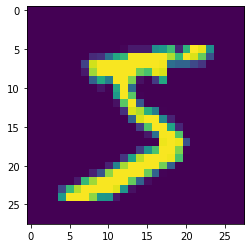

target: 5 predicted: 5


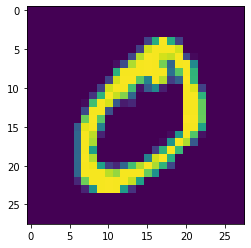

target: 0 predicted: 0


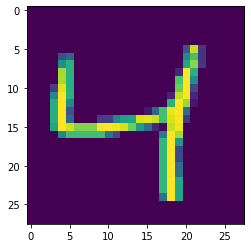

target: 4 predicted: 4


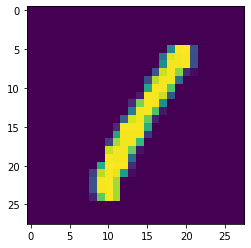

target: 1 predicted: 1


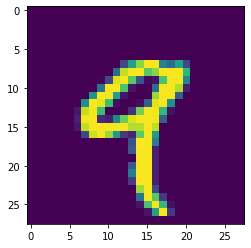

target: 9 predicted: 9


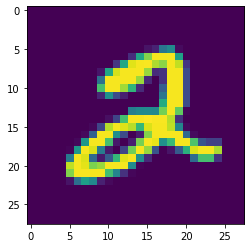

target: 2 predicted: 9


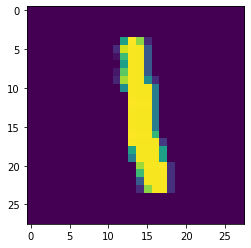

target: 1 predicted: 1


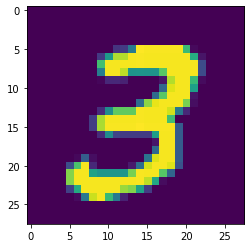

target: 3 predicted: 3


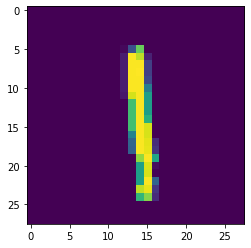

target: 1 predicted: 1


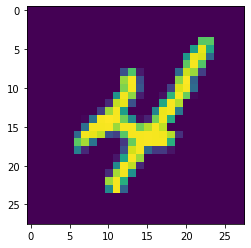

target: 4 predicted: 4


In [0]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

class Model(Layer):

    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad


simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 
for e in range(5):
    for i, (img, label) in enumerate(ld):
        x = img.view(2,-1).numpy()

        res = mm(x)
        _loss = loss(res, label.numpy())
        _loss_avg += _loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

        if i % 100 == 0:
            print(i)
            
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')
            
for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )